In [8]:
#This code was in the site given in the project description
#This function uses the pickle library to convert the
#serialized binary data to a dictionary format
#(key -> object_name, values -> images in tensor form)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [9]:
import numpy as np

# Initialize empty lists to store data and labels from each batch
train_images_list = []
train_labels_list = []

# Loop through each train batch
for i in range(1, 6):  # Batches are numbered 1 to 5
    # Load data from the current batch
    train_data = unpickle(f"data_batch_{i}")

    train_images_list.append(np.array(train_data[b"data"]))

    train_labels_list.append(np.array(train_data[b"labels"]))

# Concatenate all batch data into a single array
train_images = np.concatenate(train_images_list, axis=0)

# Concatenate all batch labels into a single array
train_labels = np.concatenate(train_labels_list, axis=0)

print(f"data -> {train_images.shape}")
print(f"labels -> {train_labels.shape}")

#Load test data
test_data = unpickle("test_batch")
test_images = np.array(test_data[b"data"])  # Shape: (10000, 3072)
test_labels = np.array(test_data[b"labels"])  # Shape: (10000,)

print(f"data -> {test_images.shape}")
print(f"labels -> {test_labels.shape}")

# Reshape images to (N, 32, 32, 3)
train_images = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

print("Training set shape:", train_images.shape)  # (50000, 32, 32, 3)
print("Test set shape:", test_images.shape)  # (10000, 32, 32, 3)

#as per the site the meta file in the folder contains class names so loading and checking

meta_data = unpickle("batches.meta")

class_names = [name.decode("utf-8") for name in meta_data[b"label_names"]]
print(class_names)



data -> (50000, 3072)
labels -> (50000,)
data -> (10000, 3072)
labels -> (10000,)
Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


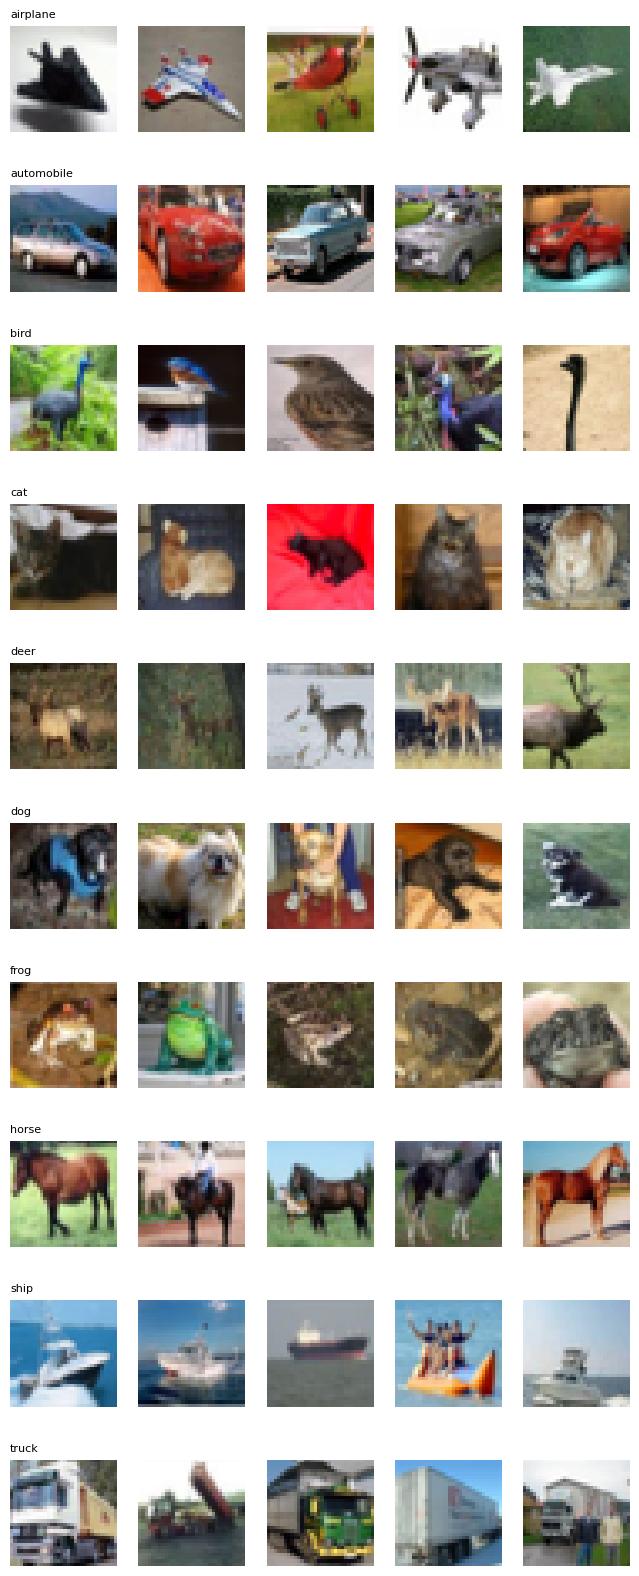

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 5, figsize=(8, 20))  # 10 rows (classes), 5 columns (images per class)
plt.subplots_adjust(hspace=0.5)

for i in range(10):  # Loop through 10 classes
    class_indices = np.where(train_labels == i)[0]  # Find indices of this class
    selected_images = class_indices[:5]  # Pick first 5 images of this class

    for j, img_idx in enumerate(selected_images):
        ax = axes[i, j]
        ax.imshow(train_images[img_idx])
        ax.axis("off")
        if j == 0:  # Add label only to the first image in each row
            ax.set_title(class_names[i], fontsize=8, loc='left')

plt.show()


In [11]:
import numpy as np

def pca_fit(images, variance_ratio=0.9):
    """Fit PCA on training images and return the transformation matrix."""
    N, H, W, C = images.shape
    flattened_images = images.reshape(N, -1)

    mean = np.mean(flattened_images, axis=0)
    std = np.std(flattened_images, axis=0) + 1e-10
    standardized_images = (flattened_images - mean) / std

    covariance_matrix = np.cov(standardized_images, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    total_variance = np.sum(eigenvalues)
    explained_variance = np.cumsum(eigenvalues) / total_variance

    optimal_components = np.argmax(explained_variance >= variance_ratio) + 1
    print(f"Optimal number of components: {optimal_components}")

    top_eigenvectors = eigenvectors[:, :optimal_components]
    reduced_train = np.dot(standardized_images, top_eigenvectors)

    return mean, std, top_eigenvectors, reduced_train

def pca_transform(images, mean, std, top_eigenvectors):
    """Transform test images using PCA computed from training images."""
    N, H, W, C = images.shape
    flattened_images = images.reshape(N, -1)

    standardized_images = (flattened_images - mean) / std
    reduced_data = np.dot(standardized_images, top_eigenvectors)

    return reduced_data

# Apply PCA only on train data
mean, std, top_eigenvectors, train_pca = pca_fit(train_images, variance_ratio=0.9)

# Transform test data using the same PCA components
test_pca = pca_transform(test_images, mean, std, top_eigenvectors)


Optimal number of components: 103


**Algorithm: Logistic Regression**

In [22]:
import numpy as np

# Softmax function for multi-class classification
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability trick
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Cross-entropy loss function
def cross_entropy_loss(y_true, y_pred):
    N = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / N  # Avoid log(0)

# One-hot encode labels
def one_hot_encode(labels, num_classes):
    N = labels.shape[0]
    one_hot = np.zeros((N, num_classes))
    one_hot[np.arange(N), labels] = 1
    return one_hot

# Logistic Regression Model
def train_logistic_regression(X, y, num_classes=10, learning_rate=0.1, epochs=500):
    N, D = X.shape  # Samples, features
    W = np.random.randn(D, num_classes) * 0.01  # Small random weights
    b = np.zeros((1, num_classes))  # Bias

    # One-hot encode labels
    y_one_hot = one_hot_encode(y, num_classes)

    for epoch in range(epochs):
        # Forward pass
        logits = np.dot(X, W) + b
        probs = softmax(logits)

        # Compute loss
        loss = cross_entropy_loss(y_one_hot, probs)

        # Compute gradients
        grad_W = np.dot(X.T, (probs - y_one_hot)) / N
        grad_b = np.sum(probs - y_one_hot, axis=0, keepdims=True) / N

        # Update weights
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")

    return W, b

# Training the model
W, b = train_logistic_regression(train_pca, train_labels)

# Predict function
def predict(X, W, b):
    logits = np.dot(X, W) + b
    probs = softmax(logits)
    return np.argmax(probs, axis=1)  # Get class with highest probability

# Make predictions on test set
test_predictions = predict(test_pca, W, b)

# Compute accuracy
accuracy = np.mean(test_predictions == test_labels)
print(f"Manual Logistic Regression Accuracy: {accuracy * 100:.2f}%")


Epoch 0: Loss = 2.3060
Epoch 100: Loss = 1.8475
Epoch 200: Loss = 1.7716
Epoch 300: Loss = 1.7492
Epoch 400: Loss = 1.7400
Manual Logistic Regression Accuracy: 40.28%


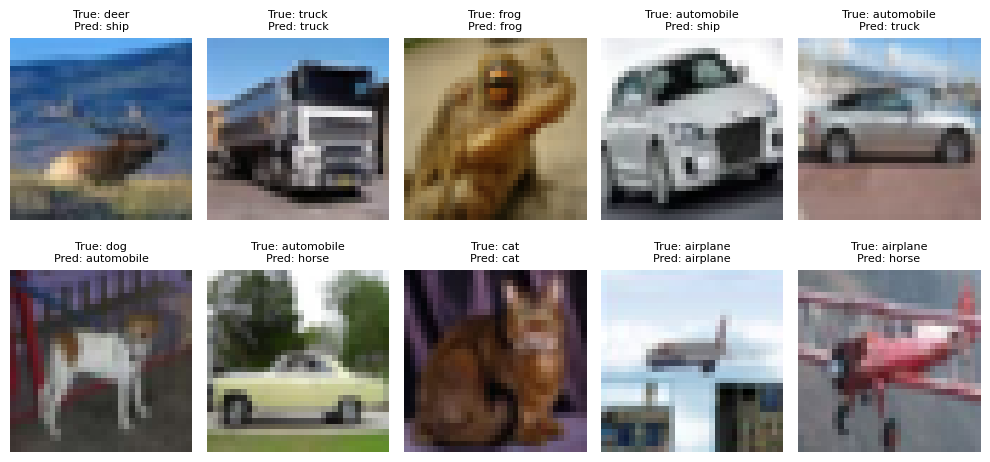

In [26]:
import matplotlib.pyplot as plt

# Select random test images
num_samples = 10  # Number of samples to visualize
indices = np.random.choice(len(test_pca), num_samples, replace=False)

# Get predictions for these samples
sample_images = test_images[indices]  # Original 32x32x3 images
sample_labels = test_labels[indices]  # True labels
sample_predictions = test_predictions_logreg[indices]  # Model's predictions

# Plot images with actual vs predicted labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 2 rows, 5 columns
axes = axes.flatten()

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(sample_images[i])
    ax.axis("off")
    ax.set_title(f"True: {class_names[sample_labels[i]]}\nPred: {class_names[sample_predictions[i]]}", fontsize=8)

plt.tight_layout()
plt.show()
